# Tree shape diversity

### The plot elements below will be saved to `/analysis/output/plots/NDS-LBI/`

In [1]:
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, LogNorm

## Load GC trees and constuct a data frame of statistics

In [2]:
results = sorted([x for x in glob.glob("../nextflow/results/*") if not x.endswith("smartseq-singularity")])[-1]
results

'../nextflow/results/2022-05-04'

In [4]:
def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), f"{PR_str[3]}-{PR_str[2]}"

files = sorted(glob.glob(f"{results}/gctrees/PR*/gctree.p"), key=gc_key)
trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
         for file in files}

print(f"loaded {len(trees)} GC trees")

loaded 77 GC trees


In [6]:
df = pd.DataFrame()

for row, (mouse_gc, tree) in enumerate(trees.items()):
    mouse, gc = mouse_gc.split("_")
    mouse = mouse.lstrip("mouse")
    
    # polytomy degree as simple branching metric
    # Duncan's local branching fraction (LBF)
    total_length = sum(node.dist for node in tree.tree.traverse())
    for node in tree.tree.traverse():
        node.add_feature("log10_polytomy_degree", np.log10(len(node.children) + node.abundance))
        node.add_feature("LBF", node.LB_down / total_length)
    
    df.loc[row, "time"] = "10-weeks" if mouse in ("7", "8") else "20 days"
    
    gc = gc.lstrip("GC")
    df.loc[row, "mouse"] = mouse
    df.loc[row, "germinal center"] = gc
    
    abundances = np.array([node.abundance for node in tree.tree.traverse()])

    if len(tree.tree.children) == 1:
        root = tree.tree.children[0]
    else:
        root = tree.tree
    clade_sizes = [sum(node.abundance for node in child.traverse()) for child in root.children]
    df.loc[row, "cells sampled"] = sum(abundances)
    df.loc[row, "normalized dominance score"] = max(clade_sizes) / sum(clade_sizes)
    df.loc[row, "maximum local branching index"] = np.nanmax([node.LBI for node in tree.tree.traverse()])    
    
    # note: additive delta_bind for now
    delta_bind_dat = []
    for node in tree.tree.traverse():
        if not np.isnan(node.delta_bind_CGG):
            for _ in range(node.abundance):
                delta_bind_dat.append(node.delta_bind_CGG)
    df.loc[row, "95th percentile affinity increase"] = np.percentile(delta_bind_dat, 95)
    df.loc[row, "median affinity increase"] = np.nanmedian(delta_bind_dat)
    df.loc[row, "maximum affinity increase"] = np.nanmax(delta_bind_dat)

    max_lbi_idx = np.nanargmax([node.LBR for node in tree.tree.traverse()])
    df.loc[row, "affinity increase of max LBI node"] = [node.delta_bind_CGG for node in tree.tree.traverse()][max_lbi_idx]

# exclude 10-week mice    
df = df.loc[df.time == "20 days"]
df


,time,mouse,germinal center,cells sampled,normalized dominance score,maximum local branching index,95th percentile affinity increase,median affinity increase,maximum affinity increase,affinity increase of max LBI node
0,20 days,1,1-RP,89.0,0.932584,18.789397,1.260416,1.124685,1.75955,1.16671
1,20 days,1,11-RB,66.0,0.742424,24.206340,1.294376,1.065520,1.87747,1.06552
2,20 days,1,12-RB,49.0,0.530612,11.536806,1.475176,1.102810,2.19856,1.47229
3,20 days,1,13-RB,88.0,0.329545,16.631421,2.034419,1.198050,2.34731,1.20278
4,20 days,1,14-RB,84.0,0.452381,14.224065,2.407759,0.825960,2.53366,0.82596
...,...,...,...,...,...,...,...,...,...,...
62,20 days,5,83-RP,78.0,0.467532,22.494044,1.196820,0.115775,1.45983,1.19682
63,20 days,6,74-RP,78.0,0.884615,23.323596,1.395440,0.557385,2.06377,1.20747
64,20 days,6,75-RP,70.0,0.985714,31.408083,1.171988,0.282890,1.19682,0.33100
65,20 days,6,76-RP,81.0,0.580247,17.027458,1.077752,0.321495,1.37717,0.68784


## Rank plot of total GC cell abundance 

In [7]:
plot_dir = "output/plots/NDS-LBI"

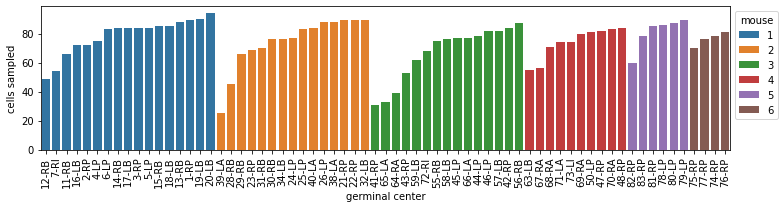

In [8]:
plt.figure(figsize=(11, 3))
ax = sns.barplot(data=df.sort_values(["mouse", "cells sampled"]), x="germinal center", y="cells sampled", hue="mouse", dodge=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f"{plot_dir}/abundances.pdf")
plt.show()

## Plot tree shape stats in a scatter plot, and render some example trees
For each tree we render it colored by LBI, then by affinity

mouse1, GC18-LB


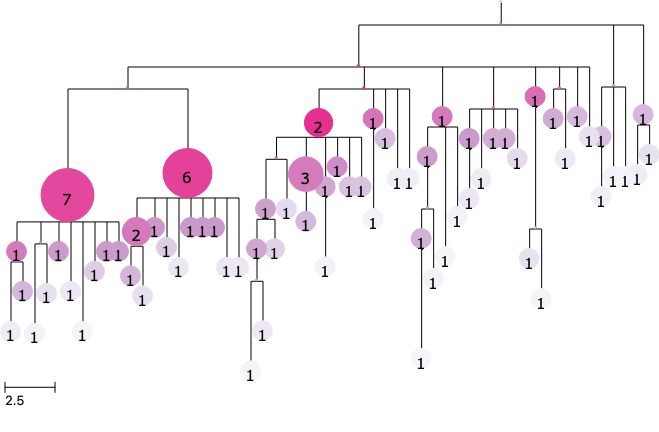

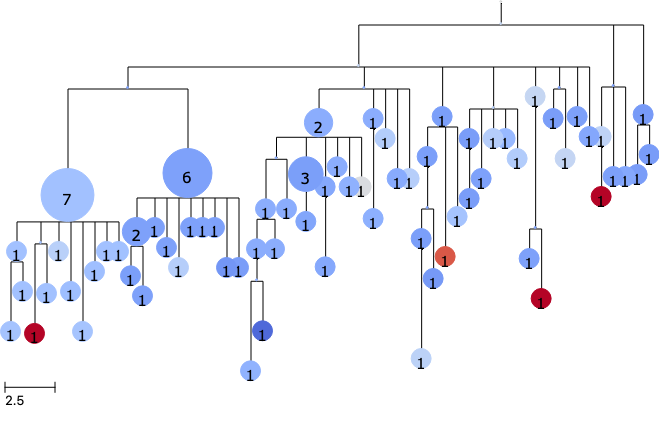

mouse2, GC21-RP


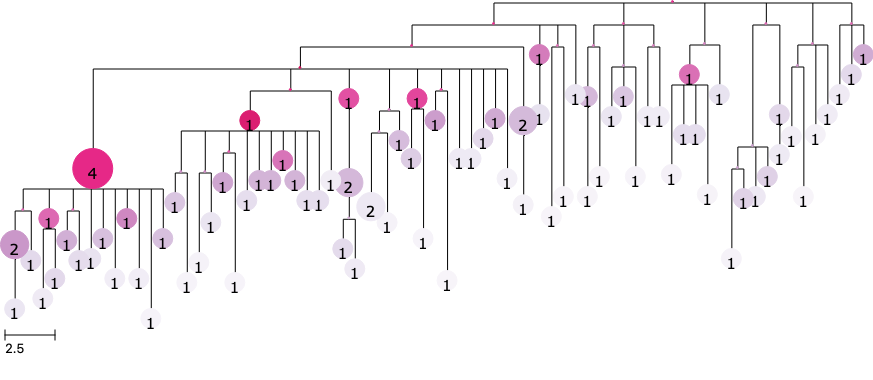

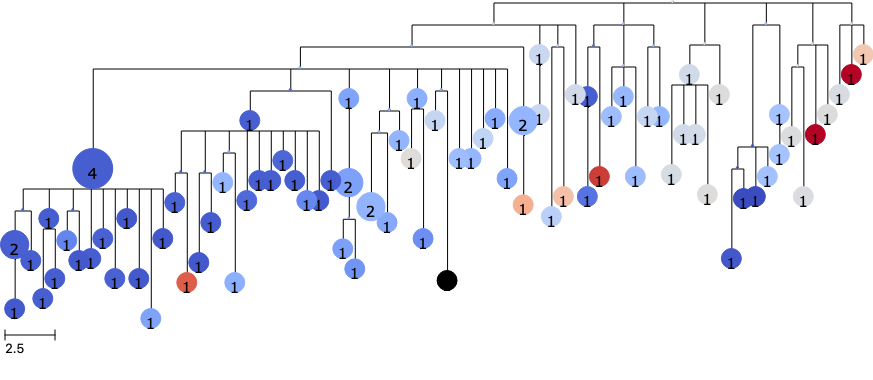

mouse2, GC34-LB


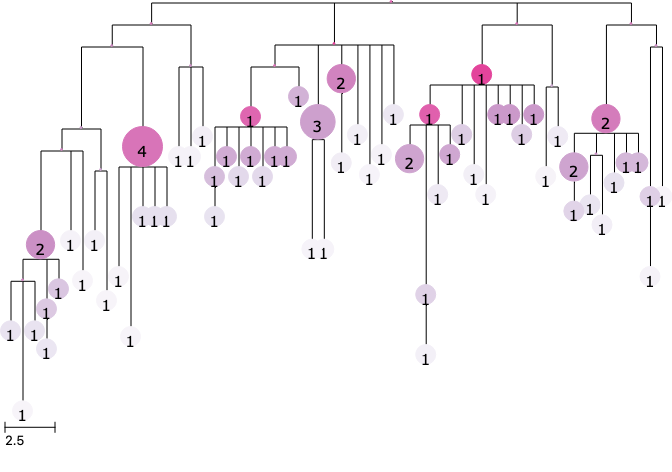

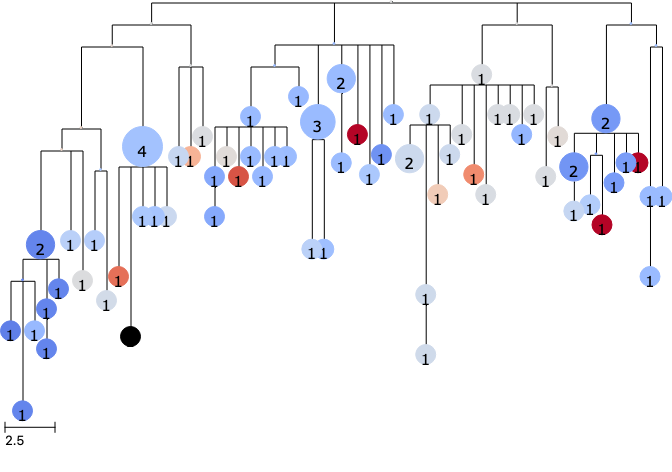

mouse2, GC38-LA


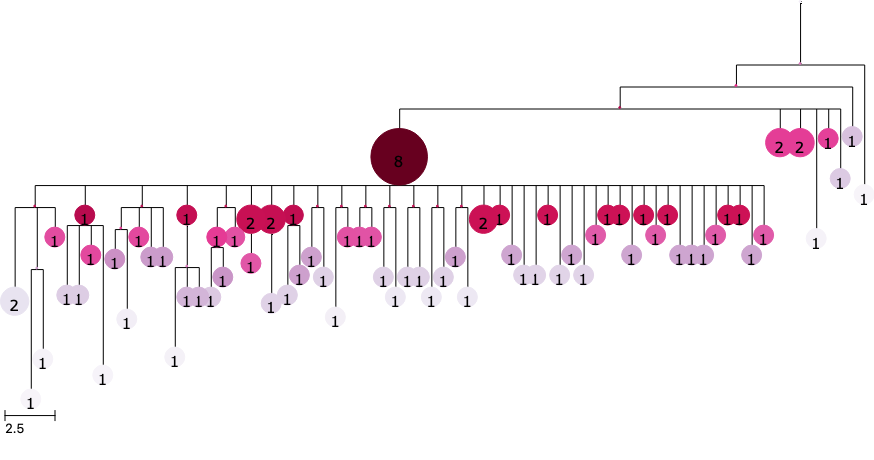

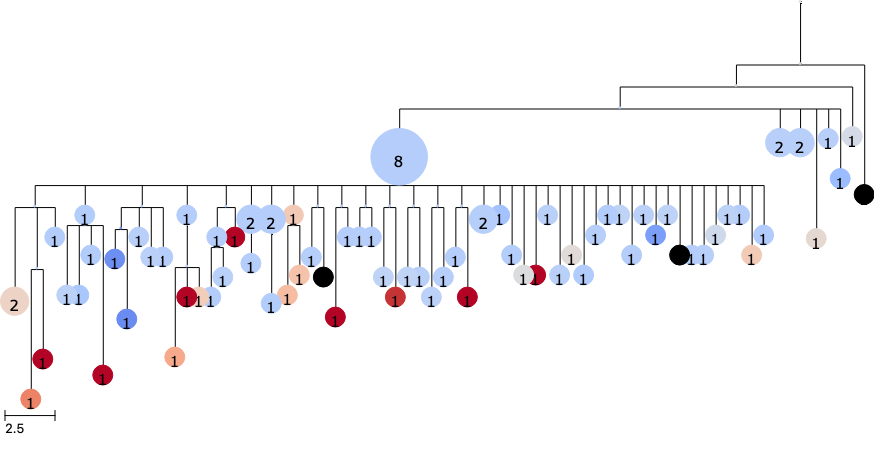

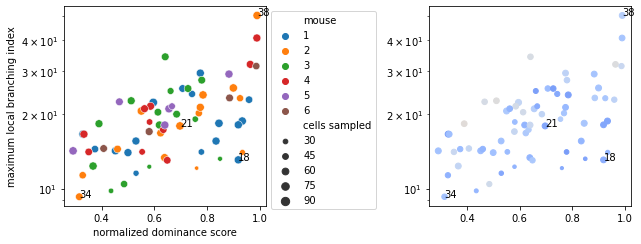

In [9]:
# LBI cmap
cmap = "PuRd"
vmin = 0
vmax = 0

# affinity cmap
cmap2 = "coolwarm_r"
vmin2 = -2
vmax2 = 2


# log10 LBI
for gc, tree in trees.items():
    for node in tree.tree.traverse():
        node.log10_LBI = np.log10(node.LBI)
        if vmin == 0 or node.LBI < vmin:
            vmin = node.LBI
        if vmax == 0 or node.LBI > vmax:
            vmax = node.LBI

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3.5), sharex=True)
sns.scatterplot(data=df, x="normalized dominance score", y="maximum local branching index", hue="mouse", size="cells sampled",
                clip_on=False, ax=ax1)
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
ax2.scatter(df["normalized dominance score"], df["maximum local branching index"], c=df["median affinity increase"], s=0.4*df["cells sampled"],
                clip_on=False,
                cmap=cmap2, vmin=vmin2, vmax=vmax2)
ax1.set_yscale("log")
ax2.set_yscale("log")
for i, row in df.iterrows():
    x, y = row[["normalized dominance score", "maximum local branching index"]]
    if (x > 0.9 and y > 45) or (x < 0.35 and y < 10) or ((.64 < x < .70) and (15 < y < 20)) or ((x > 0.9) & (y < 14)):
        print(f"mouse{row.mouse}, GC{row['germinal center']}")
        ax1.annotate(f"{row['germinal center'][:-3]}", [x, y])
        ax2.annotate(f"{row['germinal center'][:-3]}", [x, y])
        key = f"mouse{row.mouse}_GC{row['germinal center']}"
        colormap = trees[key].feature_colormap("log10_LBI", vmin=np.log10(vmin), vmax=np.log10(vmax), cmap=cmap)
        trees[key].render(f"{plot_dir}/{key}.LBI.svg", colormap=colormap, scale=20, branch_margin=-8)
        display(trees[key].render("%%inline", colormap=colormap, scale=20, branch_margin=-8))
        colormap = trees[key].feature_colormap("delta_bind_CGG", vmin=vmin2, vmax=vmax2, cmap=cmap2)
        trees[key].render(f"{plot_dir}/{key}.binding.svg", colormap=colormap, scale=20, branch_margin=-8)
        display(trees[key].render("%%inline", colormap=colormap, scale=20, branch_margin=-8))
plt.tight_layout()
plt.savefig(f"{plot_dir}/scatter.pdf")
plt.show()

## Color bars for the two tree colormaps

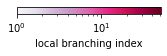

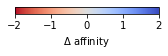

In [10]:
fig = plt.figure(figsize=(2, 1))
cax = fig.add_axes([0, 0, 1, 0.1])
plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax)),
             orientation='horizontal',
             cax=cax,
             label="local branching index")
plt.savefig(f"{plot_dir}/cbar1.pdf", bbox_inches="tight")
plt.show()

fig = plt.figure(figsize=(2, 1))
cax = fig.add_axes([0, 0, 1, 0.1])
plt.colorbar(cm.ScalarMappable(cmap=cmap2, norm=Normalize(vmin=vmin2, vmax=vmax2)),
             orientation='horizontal',
             cax=cax,
             label=r"$\Delta$ affinity")
plt.savefig(f"{plot_dir}/cbar2.pdf", bbox_inches="tight")
plt.show()